### IMPORTANDO Y CARGANDO LAS LIBRERIAS

---





In [2]:
%cd C:\Users\leoma\Desktop\projects\Modelos-de-Pronosticos-Series-Temporales-Python\Prophet+XGBoost

c:\Users\leoma\Desktop\projects\Modelos-de-Pronosticos-Series-Temporales-Python\Prophet+XGBoost


In [4]:
#IMPORTAMOS LAS LIBRERIAS
import xgboost as xgb
import itertools
from prophet import Prophet
import pandas as pd
import numpy as np

In [5]:
#OBTENEMOS LOS DATOS
data = pd.read_csv("Daily Bike Sharing.csv")
data.head(1)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [6]:
#incluimos dteday en las columnas 
dataset = data.loc[:, ["dteday","cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head()

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


### TRANSFORMACIÓN DE LOS DATOS

In [7]:
# Date variable
dataset.dteday

0      2011-01-01
1      2011-01-02
2      2011-01-03
3      2011-01-04
4      2011-01-05
          ...    
726    2012-12-27
727    2012-12-28
728    2012-12-29
729    2012-12-30
730    2012-12-31
Name: dteday, Length: 731, dtype: object

es un objeto, y puede ser un problema

In [8]:
dataset.dteday = pd.to_datetime(dataset.dteday,
                                format = "%Y-%m-%d")

In [9]:
dataset.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [10]:
#RENOMBRAMOS LA VARIABLE QUE QUEREMOS PRONOSTICAR
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset = dataset.rename(columns = {'dteday' : 'ds'})
dataset.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


### Holidays

In [11]:
holidays_dates = dataset[dataset.holiday == 1].ds
holidays_dates = pd.DataFrame({'holiday': 'holi',
                               'ds': pd.to_datetime(holidays_dates),
                               'lower_windows': -3,
                               'upper_windows': 1})
holidays_dates.head()

,holiday,ds,lower_windows,upper_windows
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [12]:
# removing holiday column
dataset = dataset.drop(columns="holiday")
dataset.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446


### CONJUNTO DE ENTRENAMIENTO Y PRUEBAS

In [13]:
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
700,2012-12-01,5191,0,2,0.298333,0.316904,0.806667,0.059704


### Facebook Prophet

In [14]:
#Facebook prophet model
m = Prophet(growth='linear', 
            yearly_seasonality= True, 
            weekly_seasonality= True, 
            daily_seasonality=False, 
            holidays= holidays_dates, 
            seasonality_mode="multiplicative", 
            seasonality_prior_scale=5, 
            holidays_prior_scale=10, 
            changepoint_prior_scale=0.01)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

19:00:11 - cmdstanpy - INFO - Chain [1] start processing
19:00:11 - cmdstanpy - INFO - Chain [1] done processing


### Forecasting

In [15]:
# Create Future Dataframe
future = m.make_future_dataframe(periods=len(test_set), 
                                 freq="D")
future.head(1)

,ds
0,2011-01-01


In [16]:
# Merge Regressors
future = pd.concat([future, dataset.iloc[:,2:]], 
                   axis=1)
future.head()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,0,2,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1,1,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1,1,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1,1,0.226957,0.229270,0.436957,0.186900


In [17]:
# Forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2407.878622,237.142965,2127.001892,2407.878622,2407.878622,-0.055594,-0.055594,-0.055594,-0.278762,...,0.000000,0.000000,0.000000,-0.273710,-0.273710,-0.273710,0.0,0.0,0.0,1205.100309
1,2011-01-02,2413.606475,65.316455,1941.873891,2413.606475,2413.606475,-0.060274,-0.060274,-0.060274,-0.287853,...,0.000000,0.000000,0.000000,-0.267571,-0.267571,-0.267571,0.0,0.0,0.0,969.364473
2,2011-01-03,2419.334328,335.322568,2262.348209,2419.334328,2419.334328,-0.138056,-0.138056,-0.138056,-0.188507,...,0.029315,0.029315,0.029315,-0.260048,-0.260048,-0.260048,0.0,0.0,0.0,1277.339755
3,2011-01-04,2425.062181,427.763658,2325.936729,2425.062181,2425.062181,-0.127303,-0.127303,-0.127303,-0.178112,...,0.029315,0.029315,0.029315,-0.251262,-0.251262,-0.251262,0.0,0.0,0.0,1365.832358
4,2011-01-05,2430.790034,639.874600,2586.285348,2430.790034,2430.790034,-0.119187,-0.119187,-0.119187,-0.111616,...,0.029315,0.029315,0.029315,-0.241355,-0.241355,-0.241355,0.0,0.0,0.0,1568.124574


### XGBoost preparations

In [18]:
Prophet_variables = forecast.loc[:,['trend','holi', 'weekly','yearly']]
df_xgb = pd.concat([dataset, Prophet_variables], axis=1)
df_xgb.head()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446,2407.878622,0.0,0.052954,-0.273710
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539,2413.606475,0.0,-0.042951,-0.267571
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309,2419.334328,0.0,-0.023473,-0.260048
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296,2425.062181,0.0,-0.007411,-0.251262
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900,2430.790034,0.0,-0.001920,-0.241355


In [55]:
#training and test set
test_days = 31
training_set = df_xgb.iloc[:-test_days, :]
test_set = df_xgb.iloc[-test_days:, :]
test_set.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
700,2012-12-01,5191,0,2,0.298333,0.316904,0.806667,0.059704,6261.348684,0.0,0.052954,-0.139025


In [56]:
# isolate X and Y
y_train=training_set.y
y_test=test_set.y
X_train=training_set.iloc[:,2:]
X_test=test_set.iloc[:,2:]


In [57]:
#create XGBoost Matrices
Train = xgb.DMatrix(data=X_train, label=y_train)
Test= xgb.DMatrix(data=X_test, label=y_test)

### XGBoost

In [58]:
#set the parameters
parameters = {'learning_rate': 0.1,
              'max_depth': 3,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight': 1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

In [59]:
#XGBoost Model
model = xgb.train(params=parameters, 
                  dtrain=Train, 
                  num_boost_round=100, 
                  evals=[(test, "y")], 
                  verbose_eval=15 )

[0]	y-rmse:1832.61811
[15]	y-rmse:1614.25134
[30]	y-rmse:1401.84964
[45]	y-rmse:1314.52188
[60]	y-rmse:1277.79918
[75]	y-rmse:1286.68507
[90]	y-rmse:1265.17708
[99]	y-rmse:1258.38030


### Forecasting and Visualization

In [60]:
#Forecasting
predictions_xgb = model.predict(Test)
predictions_xgb

array([3962.5825, 2884.727 , 6193.4644, 6404.315 , 5991.4067, 4848.893 ,
       4272.3345, 3052.5269, 2940.473 , 3518.168 , 4805.875 , 5157.6416,
       5299.681 , 5364.8154, 5022.696 , 2757.5225, 3499.6726, 5897.2915,
       5281.672 , 5246.7163, 4227.036 , 3092.6963, 3579.5264, 3267.1348,
       3174.8923, 1546.4482, 4002.5583, 4524.9814, 3132.8828, 3170.334 ,
       4341.981 ], dtype=float32)

In [61]:
#Forecasting
predictions_xgb = pd.Series(model.predict(Test), name= "XGBoost")
predictions_xgb[:2]

0    3962.582520
1    2884.727051
Name: XGBoost, dtype: float32

In [62]:
predictions_xgb.index = test_set.ds # ahora vemos la dif..como no hemos trabajado con indices..obtenemos la info de una columna
predictions_xgb[:2]

ds
2012-12-01    3962.582520
2012-12-02    2884.727051
Name: XGBoost, dtype: float32

In [66]:
#set up index
training_set.index = training_set.ds
test_set.index = test_set.ds

<AxesSubplot: xlabel='ds'>

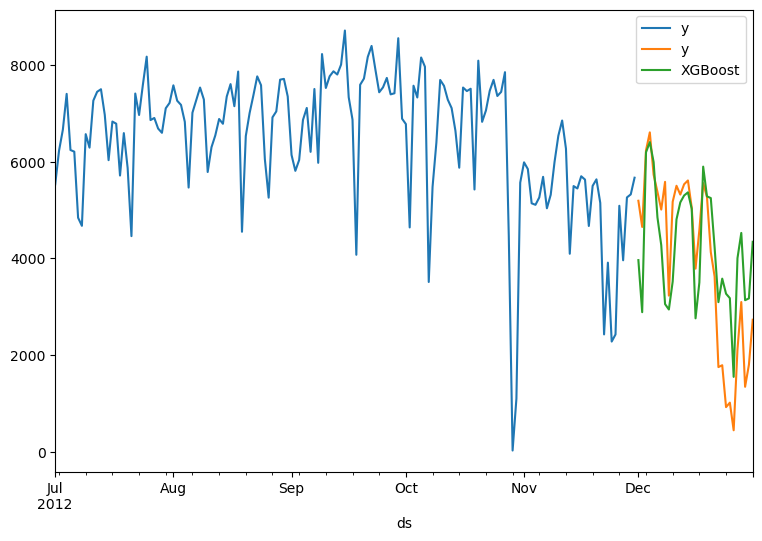

In [68]:
#Viz
training_set.y['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(figsize = (9,6), legend = True)
predictions_xgb.plot(legend=True)

### Model Assessment

In [69]:
# MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(round (mean_absolute_error(test_set['y'], predictions_xgb),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_xgb)), 0))

1020.0
1258.0


In [70]:
# MAPE function
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_xgb)

51.852559899849346

### Export forecasts

In [71]:
%cd C:\Users\leoma\Desktop\projects\Modelos-de-Pronosticos-Series-Temporales-Python

C:\Users\leoma\Desktop\projects\Modelos-de-Pronosticos-Series-Temporales-Python


In [72]:
predictions_xgb.to_csv('predictions_xgb.csv', index = True)
#prueba